## CAR Decision Trees: Regression

#### 1. Imports

In [14]:
# Import all necessary libraries.
import pandas as pd 
import numpy as np 
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

In [15]:
# Import dataset.
df = pd.read_csv("event_level_financial_metrics_with_CAR.csv")  

# Print a summary of the DataFrame to sense-check it.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fiscalDateEnding           243 non-null    object 
 1   reportedDate               243 non-null    object 
 2   reportedEPS                243 non-null    float64
 3   estimatedEPS               242 non-null    float64
 4   surprise                   243 non-null    float64
 5   surprisePercentage         242 non-null    float64
 6   reportTime                 243 non-null    object 
 7   symbol                     243 non-null    object 
 8   totalRevenue               243 non-null    int64  
 9   grossProfit                243 non-null    int64  
 10  operatingIncome            243 non-null    int64  
 11  netIncome                  243 non-null    int64  
 12  grossMargin                243 non-null    float64
 13  operatingMargin            243 non-null    float64

# 2. Update variables

In [16]:
# Create modelling categories:

# EPS surprise: collapse 5 regimes → 3 categories.
df["eps_surprise_category"] = df["eps_surprise_regime"].map({
    "large_negative": "negative",
    "moderate_negative": "negative",
    "small": "neutral",
    "moderate_positive": "positive",
    "large_positive": "positive"
})

# Rename Profitability column
df["profitability_category"] = df["profitability_regime"]

# Rename Margin trend columns
df["margin_trend_category"] = df["margin_trend_regime"]

# Deal with "missing" category in the margin_trend_category
df = df[df["margin_trend_category"] != "missing"].copy()

# Create clean modelling dataframe
df_model = df.loc[
    df["eps_surprise_category"].notna() &
    df["profitability_category"].notna() &
    df["margin_trend_category"].notna() &
    df["CAR_m5_p5"].notna() &
    df["reportedDate"].notna(),
    [
        "symbol",
        "reportedDate",
        "CAR_m5_p5",
        "eps_surprise_category",
        "profitability_category",
        "margin_trend_category"
    ]
].copy()

# --- Sanity check ---
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 1 to 242
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   symbol                  239 non-null    object 
 1   reportedDate            239 non-null    object 
 2   CAR_m5_p5               239 non-null    float64
 3   eps_surprise_category   239 non-null    object 
 4   profitability_category  239 non-null    object 
 5   margin_trend_category   239 non-null    object 
dtypes: float64(1), object(5)
memory usage: 13.1+ KB


### Note:
EPS surprise regimes were originally defined in five categories and are collapsed here into three (negative / neutral / positive) for interpretability and sample-size stability in the decision tree.

In [17]:
# Sanity check
print("EPS categories:")
print(df_model["eps_surprise_category"].value_counts())

EPS categories:
eps_surprise_category
positive    158
neutral      56
negative     25
Name: count, dtype: int64


In [18]:
print("\nProfitability categories:")
print(df_model["profitability_category"].value_counts())


Profitability categories:
profitability_category
high      147
medium     81
low        11
Name: count, dtype: int64


In [19]:
print("\nMargin trend categories:")
print(df_model["margin_trend_category"].value_counts())


Margin trend categories:
margin_trend_category
expansion      115
contraction     98
stable          26
Name: count, dtype: int64


In [20]:
# Check value counts per metric, per company.
for sym, d in df_model.groupby("symbol"):
    print(f"\n=== {sym} | n = {len(d)} ===")
    print("EPS surprise:")
    print(d["eps_surprise_category"].value_counts())
    print("\nProfitability:")
    print(d["profitability_category"].value_counts())
    print("\nMargin trend:")
    print(d["margin_trend_category"].value_counts())


=== AAPL | n = 80 ===
EPS surprise:
eps_surprise_category
positive    52
neutral     24
negative     4
Name: count, dtype: int64

Profitability:
profitability_category
high      57
medium    23
Name: count, dtype: int64

Margin trend:
margin_trend_category
expansion      36
contraction    32
stable         12
Name: count, dtype: int64

=== GOOGL | n = 80 ===
EPS surprise:
eps_surprise_category
positive    46
neutral     19
negative    15
Name: count, dtype: int64

Profitability:
profitability_category
high      61
medium    18
low        1
Name: count, dtype: int64

Margin trend:
margin_trend_category
contraction    39
expansion      35
stable          6
Name: count, dtype: int64

=== NVDA | n = 79 ===
EPS surprise:
eps_surprise_category
positive    60
neutral     13
negative     6
Name: count, dtype: int64

Profitability:
profitability_category
medium    40
high      29
low       10
Name: count, dtype: int64

Margin trend:
margin_trend_category
expansion      44
contraction    27
sta

### Observations:
**Note on sample sizes and company-level trees**

We build a separate decision tree for each company because the financial signals behave quite differently across firms.  
Each company has around 80 earnings events, which is enough for a simple, shallow tree, but some categories are much more common than others (for example, consistently high profitability at Apple, or mostly positive EPS surprises at NVIDIA).  

Rather than forcing the model to use every metric, we include the same set of signals for all companies and allow the tree to decide which ones matter in each case. Where a signal does not vary much for a company, it naturally drops out of the tree. This reflects genuine differences in company behaviour rather than a modelling choice.

## Fit one shallow regression tree per company (full sample)

In [21]:
# 1) Basic checks (optional but helpful) ---
required_cols = ["symbol", "CAR_m5_p5", "eps_surprise_category",
                 "profitability_category", "margin_trend_category"]
missing = [c for c in required_cols if c not in df_model.columns]
if missing:
    raise ValueError(f"df_model is missing required columns: {missing}")

In [22]:
# 2) Ordinal encodings (keep consistent across companies)
eps_ord = {"negative": 0, "neutral": 1, "positive": 2}
prof_ord = {"low": 0, "medium": 1, "high": 2}
margin_ord = {"contraction": 0, "stable": 1, "expansion": 2}

df_trees = df_model.copy()
df_trees["eps_enc"] = df_trees["eps_surprise_category"].map(eps_ord)
df_trees["prof_enc"] = df_trees["profitability_category"].map(prof_ord)
df_trees["margin_enc"] = df_trees["margin_trend_category"].map(margin_ord)

# Drop any rows that failed mapping (should be none if your categories are clean)
df_trees = df_trees.dropna(subset=["eps_enc", "prof_enc", "margin_enc", "CAR_m5_p5"]).copy()

features = ["eps_enc", "prof_enc", "margin_enc"]

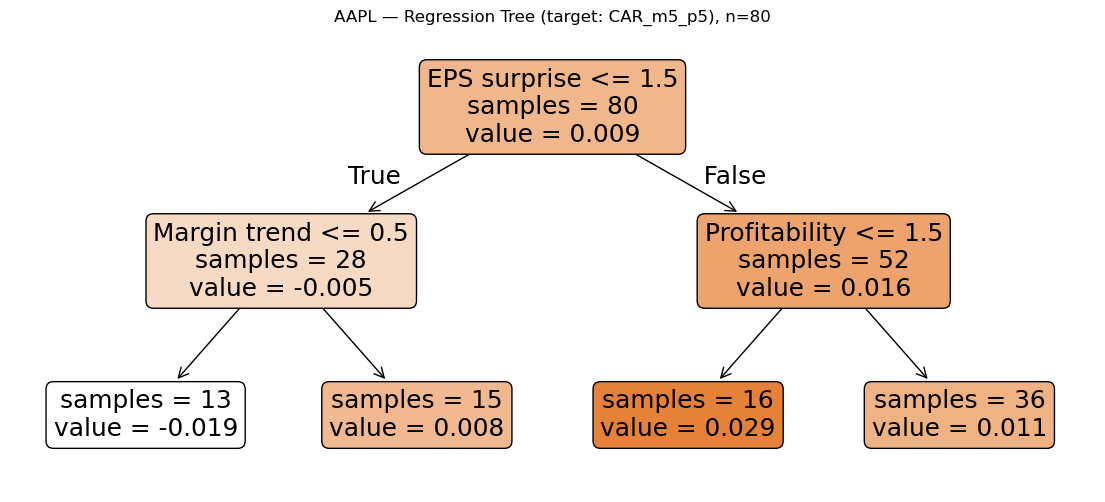

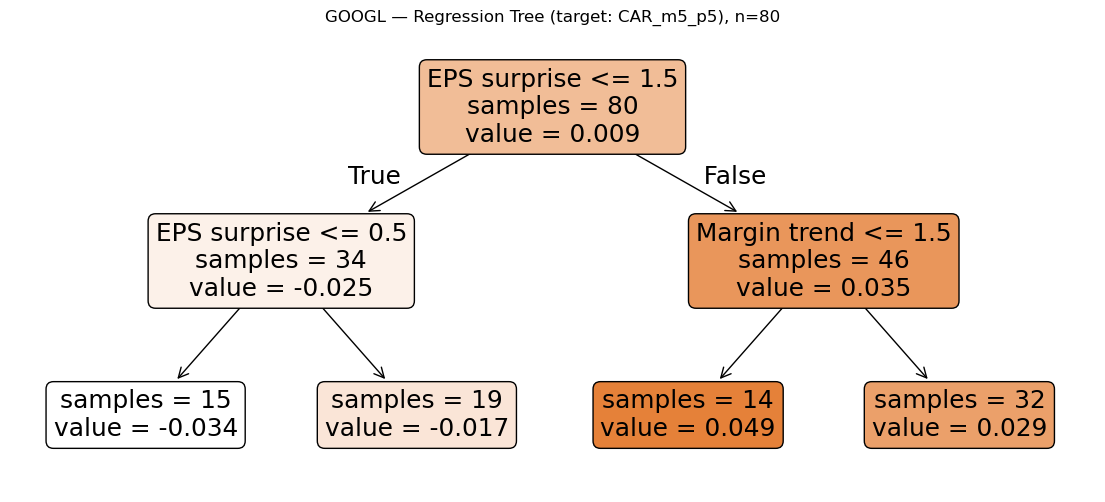

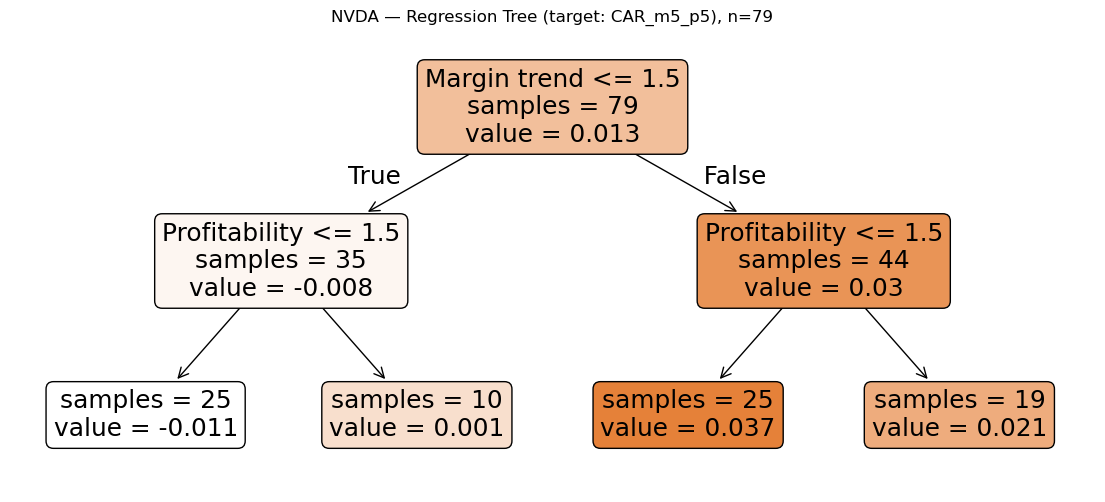

Fitted trees: ['AAPL', 'GOOGL', 'NVDA']
Rows used per company: {'AAPL': {'n_rows': 80}, 'GOOGL': {'n_rows': 80}, 'NVDA': {'n_rows': 79}}


In [27]:
# 3) Fit trees and plot them
trees = {}   # stores the fitted model per company
train_meta = {}  # simple metadata (n used) per company

for sym, d in df_trees.groupby("symbol"):
    X = d[features]
    y = d["CAR_m5_p5"]

    # Guardrail: don't fit if too few rows
    if len(d) < 20:
        print(f"Skipping {sym}: only {len(d)} rows after cleaning/encoding")
        continue

    tree = DecisionTreeRegressor(
        max_depth=2,
        min_samples_leaf=10,
        random_state=42
    )
    tree.fit(X, y)

    trees[sym] = tree
    train_meta[sym] = {"n_rows": len(d)}

    # Plot (slide-friendly)
    plt.figure(figsize=(14, 6))
    plot_tree(
        tree,
        feature_names=["EPS surprise", "Profitability", "Margin trend"],
        filled=True,
        rounded=True,
        impurity=False,
        proportion=False
    )
    plt.title(f"{sym} — Regression Tree (target: CAR_m5_p5), n={len(d)}")
    plt.savefig("car_regression_trees.png", dpi=300, bbox_inches="tight")
    plt.show()

print("Fitted trees:", list(trees.keys()))
print("Rows used per company:", train_meta)

### Leaf-level summaries for each company (full sample)

In [24]:
leaf_summaries = {}

for sym, tree in trees.items():
    d = df_trees[df_trees["symbol"] == sym].copy()

    X = d[features]
    d["leaf_id"] = tree.apply(X)

    summary = (
        d.groupby("leaf_id")["CAR_m5_p5"]
        .agg(
            n="count",
            mean="mean",
            median="median",
            std="std",
            min="min",
            max="max"
        )
        .sort_values("mean", ascending=False)
    )

    leaf_summaries[sym] = summary

    print(f"\n=== {sym} — Leaf summary (full sample) ===")
    plt.savefig("margin_trend_by_firm.png", dpi=300, bbox_inches="tight")
    display(summary)


=== AAPL — Leaf summary (full sample) ===


,n,mean,median,std,min,max
leaf_id,,,,,,
5,16,0.029312,0.036532,0.054079,-0.096408,0.110612
6,36,0.010560,0.008306,0.043978,-0.094043,0.131278
3,15,0.007581,0.016184,0.083231,-0.175706,0.170023
2,13,-0.019306,-0.034011,0.048790,-0.089711,0.070279



=== GOOGL — Leaf summary (full sample) ===


,n,mean,median,std,min,max
leaf_id,,,,,,
5,14,0.049116,0.042263,0.061594,-0.036471,0.186543
6,32,0.028648,0.023870,0.064581,-0.071115,0.194509
3,19,-0.017396,-0.028843,0.064902,-0.134684,0.124603
2,15,-0.034330,-0.025382,0.055934,-0.145067,0.055864



=== NVDA — Leaf summary (full sample) ===


,n,mean,median,std,min,max
leaf_id,,,,,,
5,25,0.037425,0.035352,0.057705,-0.069620,0.186779
6,19,0.020719,0.006401,0.094152,-0.168781,0.203862
3,10,0.001100,-0.004547,0.072984,-0.075591,0.188932
2,25,-0.011166,-0.021525,0.099060,-0.277765,0.198861


**Apple (AAPL) — full sample**
Apple shows a clear ranking of outcomes across different sets of conditions.  
When earnings beat expectations, post-earnings returns are generally positive, with the strongest outcomes occurring when profitability is not already high. When earnings are neutral or negative, margin trends become important: contracting margins are associated with negative returns, while stable or improving margins soften the impact. Overall, EPS surprise is the primary driver, with margins and profitability refining the outcome.

**Alphabet (GOOGL) — full sample**
Google displays stronger separation between positive and negative sets of conditions than Apple. Certain combinations around earnings are associated with very strong positive returns on average, while others are clearly negative. Both the upside and downside outcomes are larger in magnitude than for Apple, suggesting greater sensitivity to earnings-related signals. The distinction between favourable and unfavourable conditions is relatively sharp.

**Alphabet (GOOGL) — full sample**
Google displays stronger separation between positive and negative sets of conditions than Apple. Certain combinations around earnings are associated with very strong positive returns on average, while others are clearly negative. Both the upside and downside outcomes are larger in magnitude than for Apple, suggesting greater sensitivity to earnings-related signals. The distinction between favourable and unfavourable conditions is relatively sharp.

### Apply full-sample leaf definitions to 2022-2025

In [25]:
# 1) Define the recent period:
df_recent = df_trees[
    (pd.to_datetime(df_trees["reportedDate"]) >= "2022-01-01") &
    (pd.to_datetime(df_trees["reportedDate"]) <= "2025-12-31")
].copy()

comparison_tables = {}

for sym, tree in trees.items():
    d_full = df_trees[df_trees["symbol"] == sym].copy()
    d_recent = df_recent[df_recent["symbol"] == sym].copy()

    # Assign leaves using the SAME tree (no retraining)
    d_full["leaf_id"] = tree.apply(d_full[features])
    d_recent["leaf_id"] = tree.apply(d_recent[features])

    # Full-sample summary
    full_summary = (
        d_full.groupby("leaf_id")["CAR_m5_p5"]
        .agg(
            n_full="count",
            mean_full="mean",
            median_full="median"
        )
    )

    # Recent-period summary
    recent_summary = (
        d_recent.groupby("leaf_id")["CAR_m5_p5"]
        .agg(
            n_recent="count",
            mean_recent="mean",
            median_recent="median"
        )
    )

    # Combine
    comparison = (
        full_summary
        .join(recent_summary, how="left")
        .sort_values("mean_full", ascending=False)
    )

    comparison_tables[sym] = comparison

    print(f"\n=== {sym} — Full sample vs 2022–2025 ===")
    display(comparison)


=== AAPL — Full sample vs 2022–2025 ===


,n_full,mean_full,median_full,n_recent,mean_recent,median_recent
leaf_id,,,,,,
5,16,0.029312,0.036532,NaN,NaN,NaN
6,36,0.010560,0.008306,10.0,-0.005535,-0.003576
3,15,0.007581,0.016184,3.0,0.027912,0.016184
2,13,-0.019306,-0.034011,3.0,-0.011641,-0.040986



=== GOOGL — Full sample vs 2022–2025 ===


,n_full,mean_full,median_full,n_recent,mean_recent,median_recent
leaf_id,,,,,,
5,14,0.049116,0.042263,2,0.056654,0.056654
6,32,0.028648,0.023870,7,0.026440,0.039079
3,19,-0.017396,-0.028843,3,-0.048311,-0.047350
2,15,-0.034330,-0.025382,4,-0.021676,-0.027957



=== NVDA — Full sample vs 2022–2025 ===


,n_full,mean_full,median_full,n_recent,mean_recent,median_recent
leaf_id,,,,,,
5,25,0.037425,0.035352,2,0.059300,0.059300
6,19,0.020719,0.006401,8,0.027850,0.003793
3,10,0.001100,-0.004547,4,-0.036096,-0.042001
2,25,-0.011166,-0.021525,2,-0.026929,-0.026929


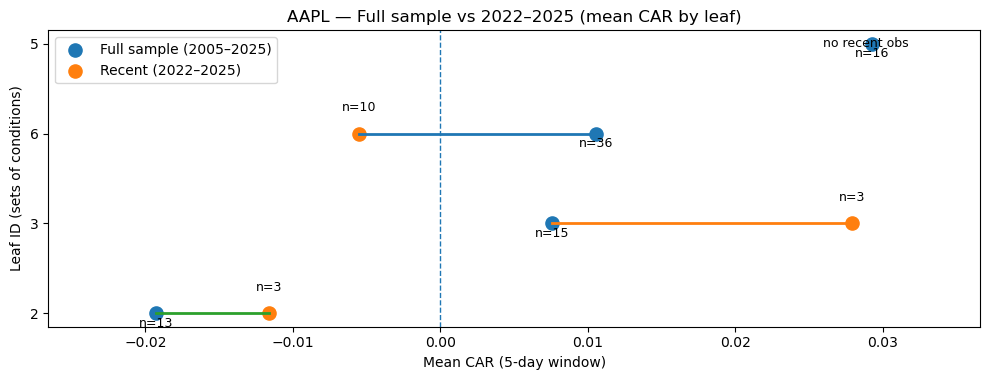

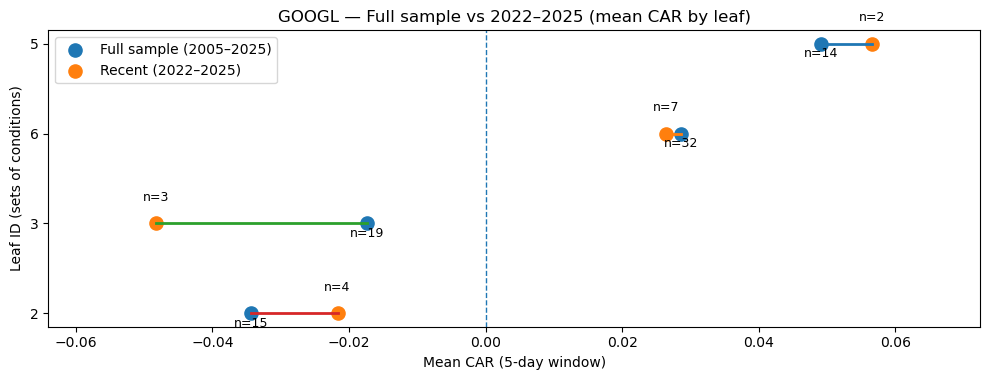

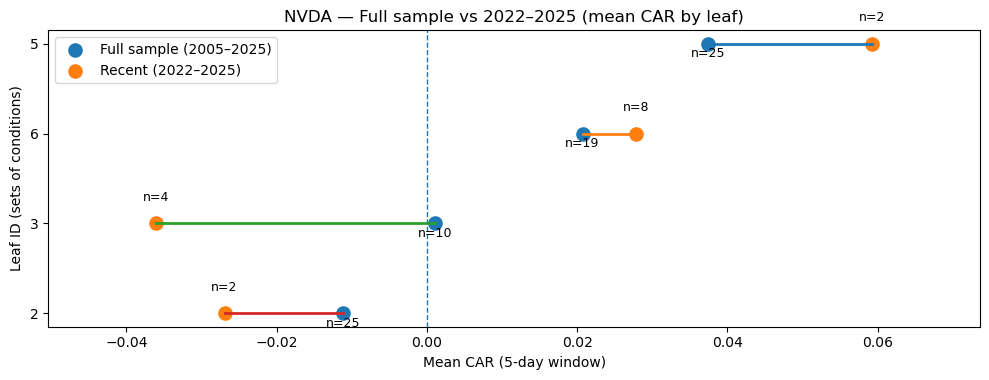

In [26]:
def plot_leaf_comparison_dumbbell(
    comparison_tables: dict,
    company: str,
    sort_by: str = "mean_full",
    show_n_labels: bool = True,
    xlim: tuple | None = None,
):
    """
    comparison_tables: dict like {"AAPL": df, "GOOGL": df, ...}
    each df has columns: n_full, mean_full, median_full, n_recent, mean_recent, median_recent
    index: leaf_id
    """
    comp = comparison_tables[company].copy()

    # Keep only rows that have full-sample info
    comp = comp.dropna(subset=["mean_full"])

    # Sort leaves by full-sample mean (recommended)
    comp = comp.sort_values(sort_by, ascending=False)

    leaf_ids = comp.index.astype(str).tolist()
    y = np.arange(len(comp))

    x_full = comp["mean_full"].to_numpy()
    x_recent = comp["mean_recent"].to_numpy()  # may include NaN
    n_full = comp["n_full"].to_numpy()
    n_recent = comp["n_recent"].to_numpy()

    fig, ax = plt.subplots(figsize=(10, 0.6 * len(comp) + 1.5))

    # Draw connecting lines (only where recent exists)
    for i in range(len(comp)):
        if np.isfinite(x_recent[i]):
            ax.plot([x_full[i], x_recent[i]], [y[i], y[i]], linewidth=2)

    # Plot points
    ax.scatter(x_full, y, s=90, label="Full sample (2005–2025)")
    mask_recent = np.isfinite(x_recent)
    ax.scatter(x_recent[mask_recent], y[mask_recent], s=90, label="Recent (2022–2025)")

    # Annotate sample sizes (optional)
    if show_n_labels:
        for i in range(len(comp)):
            ax.text(x_full[i], y[i] + 0.15, f"n={int(n_full[i])}", fontsize=9, ha="center")
            if np.isfinite(x_recent[i]) and not pd.isna(n_recent[i]):
                ax.text(x_recent[i], y[i] - 0.25, f"n={int(n_recent[i])}", fontsize=9, ha="center")
            else:
                # If no recent data for that leaf, show a small note on the right
                ax.text(ax.get_xlim()[1] if xlim is None else xlim[1], y[i],
                        "no recent obs", fontsize=9, va="center", ha="right")

    # Cosmetics
    ax.set_yticks(y)
    ax.set_yticklabels(leaf_ids)
    ax.invert_yaxis()  # top leaf = highest mean_full
    ax.axvline(0, linestyle="--", linewidth=1)
    ax.set_xlabel("Mean CAR (5-day window)")
    ax.set_ylabel("Leaf ID (sets of conditions)")
    ax.set_title(f"{company} — Full sample vs 2022–2025 (mean CAR by leaf)")
    ax.legend(loc="best")

    # Optional x-limits
    if xlim is not None:
        ax.set_xlim(xlim)
    else:
        # Auto padding around min/max across full & recent
        xs = np.concatenate([x_full, x_recent[mask_recent]]) if mask_recent.any() else x_full
        pad = (xs.max() - xs.min()) * 0.15 if xs.max() != xs.min() else 0.02
        ax.set_xlim(xs.min() - pad, xs.max() + pad)

    plt.tight_layout()
    plt.show()


# --- Plot all companies ---
for sym in comparison_tables.keys():
    plot_leaf_comparison_dumbbell(comparison_tables, sym, show_n_labels=True)

### Observations:
Applying the same sets of conditions to the 2022–2025 period shows mixed results. For Google and NVIDIA, the relative ordering of favourable and unfavourable outcomes remains broadly consistent with the full sample, suggesting that these earnings-related patterns remain relevant. For Apple, recent results are less aligned with historical patterns, with some strong historical conditions not occurring and others producing weaker outcomes. This suggests that Apple’s short-term market response to earnings may have changed in the recent period.

### Conclusions

We analysed earnings announcements for Apple, Google, and NVIDIA using a simple decision-tree approach to identify sets of earnings-related conditions (EPS surprise, profitability, and margin trend) associated with short-term post-earnings returns.
The trees were trained on the full historical sample and then applied unchanged to the 2022–2025 period to assess how relevant these patterns remain today.



Apple (AAPL)
Full-period pattern
Historically, Apple’s strongest post-earnings returns occurred when EPS surprises were positive, especially when profitability was not already high. When EPS was neutral or negative, margin trends became important, with contracting margins associated with negative outcomes.

Recent-period conclusion (2022–2025)
These historical patterns are less stable in the recent period, with some favourable conditions not occurring and others producing weaker or mixed outcomes. For Apple, earnings conditions currently provide lower-confidence short-term signals.


Alphabet (GOOGL)

Full-period pattern
Google shows a clear separation between favourable and unfavourable sets of conditions, with positive EPS surprises typically followed by positive returns and neutral or negative surprises followed by declines.

Recent-period conclusion (2022–2025)
This structure remains largely intact in the recent period, with positive and negative conditions continuing to behave as expected. Earnings conditions therefore remain a useful short-term guide for Google.



NVIDIA (NVDA)

Full-period pattern
NVIDIA exhibits the strongest reactions to earnings conditions, with some sets of conditions associated with large positive returns and others with sharp declines. Volatility is high, but the direction of outcomes is clearly linked to earnings signals.

Recent-period conclusion (2022–2025)
The directional patterns persist, although outcomes are more volatile. Earnings conditions remain highly relevant for NVIDIA, but investors should expect larger swings and less stability.

Overall summary:
Across the three companies, earnings conditions remain most actionable for Google and NVIDIA, while Apple’s short-term post-earnings response appears to have changed in the recent period, reducing the reliability of historical patterns.

# 